# This notebook illustrates cell cycle scoring in Xenopus

## Imports

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony

import random
np.random.seed(0)
random.seed(0)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Load data

In [2]:
def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [3]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [14]:
#loading and concatenating files
timepoints = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , timepoints)



In [9]:
counts = concat_for_harmony(adatas, timepoints)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])



st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


## mapping to human orthologs

In [9]:
# Loading gene mapping file

In [13]:
df = pd.read_csv('../misc_files/XENLA_XenBase20190115_prot.txt', sep = '\t', index_col = 0)

In [6]:
df.head()

,BestName,BestBits,HsName,HsBits,Unnamed: 5,Unnamed: 6
#SeqID,,,,,,
LOC108711435,gene49202,rna95089,NoName-TF330718,59.07.00,NoName,00.00
LOC108716471,gene43819,rna87416,NoName-TF102004.PRKCQ,71.06.00,PRKCQ,64.70
xclca2,gene35676,rna75734,CLCA1,1501.00.00,CLCA1,784.00.00
selenof.L,gene50969,rna97687,NoName-TF315117.SEP15,211.00.00,RP4-604K5.1,199.00.00
keap1.L,gene5412,rna15869,NoName-TF351653.KLHL24,227.00.00,KLHL7,224.00.00


In [7]:
mapper = {x:h for x,h in zip(df.index, df['Unnamed: 5'])}

In [8]:
df_map = pd.DataFrame({'Data_name':counts.columns,
              'Reduced_name': [x.split('|')[1] for x in counts.columns]
             })

In [9]:
df_map['Human_name'] = df_map.Reduced_name.map(mapper)

In [10]:
df_map = df_map.replace('NoName', np.NaN).dropna()
df_map.head()

,Data_name,Reduced_name,Human_name
0,gene38407|LOC108700169,LOC108700169,KLHL9
2,gene6322|usp8.L,usp8.L,USP8
3,gene799|s1pr3.L,s1pr3.L,S1PR3
4,gene47248|LOC108717406,LOC108717406,HDDC3
5,gene580|snx33.L,snx33.L,SNX33


In [17]:
cell_cycle_genes = [x.strip() for x in open('../misc_files/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
len(g2m_genes)

54

In [12]:
mapper = {x:h for x,h in zip(df_map.Data_name, df_map.Human_name)}

In [13]:
mappable_genes = df_map.Data_name.tolist()
sub = norm_df.loc[:,[i in mappable_genes for i in counts.columns]]

In [14]:
sub.columns = [mapper[i] for i in sub.columns]

In [15]:
sub = sub.T

In [18]:
sub = sub.loc[cell_cycle_genes]
ct_map = {x:y for x, y in zip(cell_cycle_genes,[*['S']*43, *['G2M']*54] )}
sub['type'] = [ct_map[i] for i in sub.index]


sub.dropna(inplace = True)

## Mean expression of cell-cycle gene groups

In [19]:
means = sub.groupby('type').mean().T

In [20]:
with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

#Cluster to color mapping table
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [21]:

tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [22]:
cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


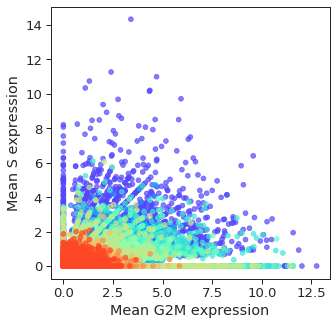

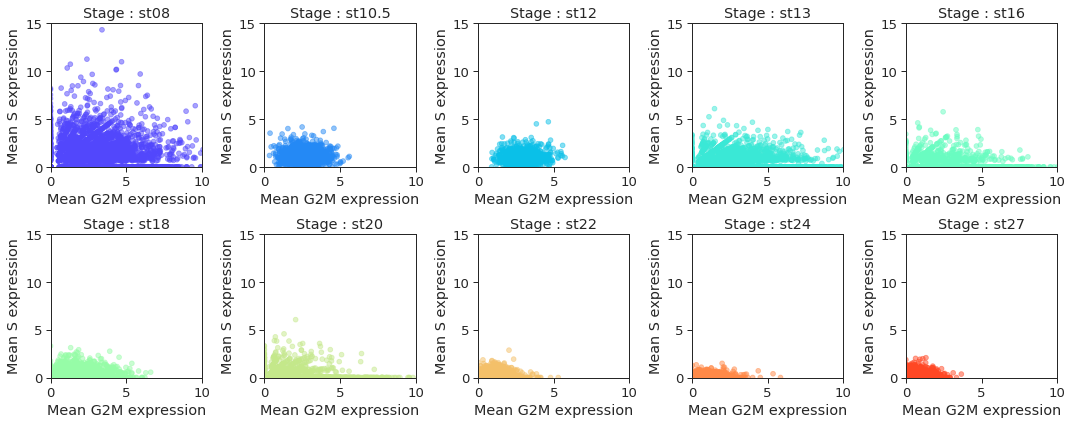

In [23]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.scatter(x = means.G2M, 
           y = means.S, 
           c = cluster_colors[tp],
           alpha = 0.7)
ax.set_xlabel('Mean G2M expression')
ax.set_ylabel('Mean S expression')
plt.savefig('cellcycle_score_stages.pdf')

fig, ax = plt.subplots(2,5,figsize = (15,6))
ax = np.ravel(ax)
for idx, i in enumerate(tp.unique()):
    cells = tp[tp == i].index
    ax[idx].scatter(x = means.loc[cells].G2M, 
                    y = means.loc[cells].S, 
                    c = cluster_colors[tp[cells]],
                    alpha = 0.5)
    ax[idx].set_xlabel('Mean G2M expression')
    ax[idx].set_ylabel('Mean S expression')
    ax[idx].set_ylim(0,15)
    ax[idx].set_xlim(0,10)
    ax[idx].set_title('Stage : {}'.format(i))
plt.tight_layout()
plt.savefig('cellcycle_score_ind_stages.pdf')




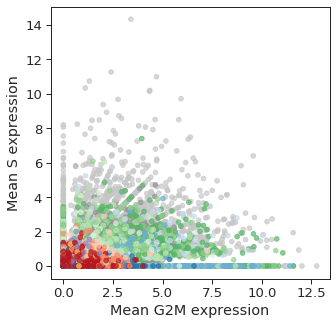

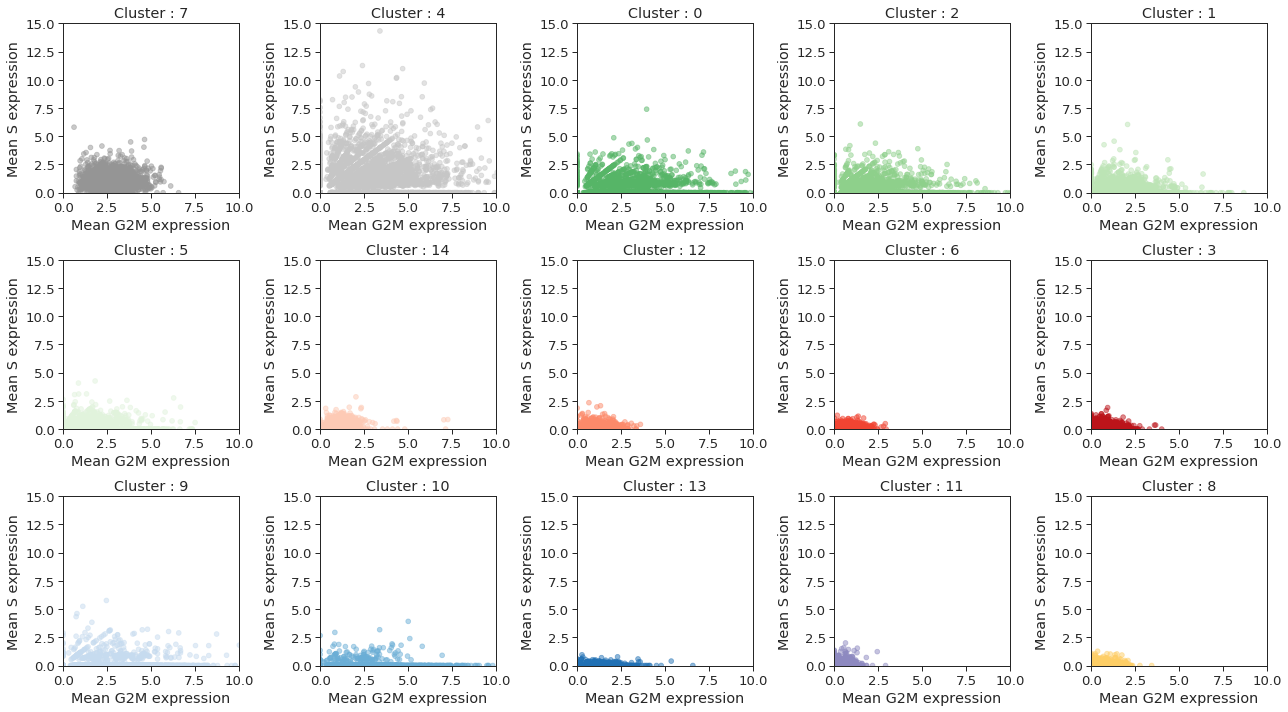

In [24]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.scatter(x = means.G2M, 
           y = means.S, 
           c = colors.color[clusters],
           alpha = 0.7)
ax.set_xlabel('Mean G2M expression')
ax.set_ylabel('Mean S expression')
plt.savefig('cellcycle_score_clusters.pdf')

fig, ax = plt.subplots(3,5,figsize = (18,10))
ax = np.ravel(ax)
for idx, i in enumerate(colors.sort_values('clust_order').org_clust.values):
    cells = clusters[clusters == i].index
    ax[idx].scatter(x = means.loc[cells].G2M, 
                    y = means.loc[cells].S, 
                    c = colors.color[clusters[cells]],
                    alpha = 0.5)
    ax[idx].set_xlabel('Mean G2M expression')
    ax[idx].set_ylabel('Mean S expression')
    ax[idx].set_ylim(0,15)
    ax[idx].set_xlim(0,10)
    ax[idx].set_title('Cluster : {}'.format(i))
plt.tight_layout()
plt.savefig('cellcycle_score_ind_clusters.pdf')




## Cell cycle phase classification

In [35]:
mapper = {h:d for h, d in zip(df_map.Human_name, df_map.Data_name)}


def convert_genes(ls):
    new_names = []
    for i in ls:
        try: 
            new_names.append(mapper[i])
        except: pass
    return new_names
        
    

In [28]:
counts.columns = new_names

In [44]:
#Make scanpy object
merge = sc.AnnData(counts)

merge.obs['stage'] = tp
merge.obs['cluster'] = clusters

sc.pp.normalize_per_cell(merge, counts_per_cell_after=1e4)
sc.pp.log1p(merge)
sc.pp.scale(merge, max_value=10)

In [45]:
cell_cycle_genes = [x.strip() for x in open('../misc_files/regev_lab_cell_cycle_genes.txt')]

cc_genes = convert_genes(cell_cycle_genes)
s_genes = convert_genes(cell_cycle_genes[:43])
g2m_genes = convert_genes(cell_cycle_genes[43:])

cell_cycle_genes = [x for x in cc_genes if x in merge.var_names]

sc.tl.score_genes_cell_cycle(merge, s_genes=s_genes, g2m_genes=g2m_genes)



... storing 'stage' as categorical
... storing 'phase' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be av

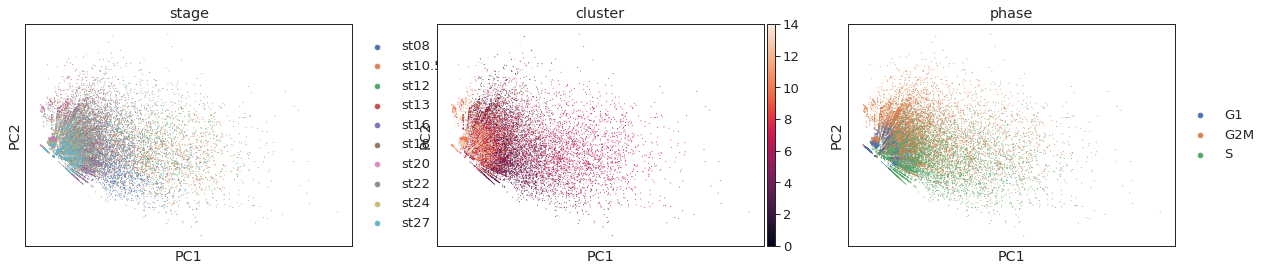

In [48]:
adata_cc_genes = merge[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca(adata_cc_genes, color = ['stage', 'cluster', 'phase'])

In [107]:
merge.obs.phase.to_csv('../Sup_tables/Intermediate/cc_phase.tsv', sep = '\t')

In [110]:
color=['#b0e7ff', '#5eceff','#00a5ed']
order = ['G1', 'S', 'G2M']

In [111]:
st = pd.crosstab(merge.obs.stage, merge.obs.phase)
st_pct = st.div(st.sum(axis = 1), axis = 0) * 100

In [112]:
cl = pd.crosstab(merge.obs.cluster, merge.obs.phase)
cl_pct = cl.div(cl.sum(axis = 1), axis = 0) * 100

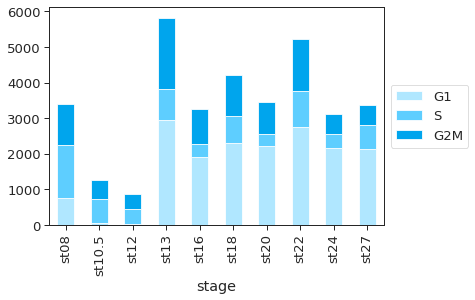

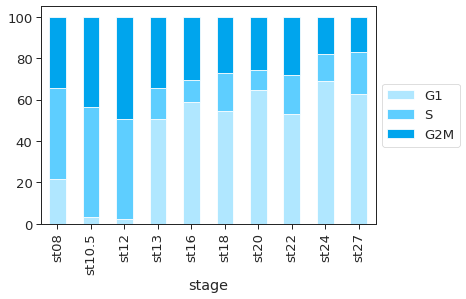

In [113]:

st.loc[:,order].plot.bar(stacked=True, color = color)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
st_pct.loc[:,order].plot.bar(stacked=True, color = color)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

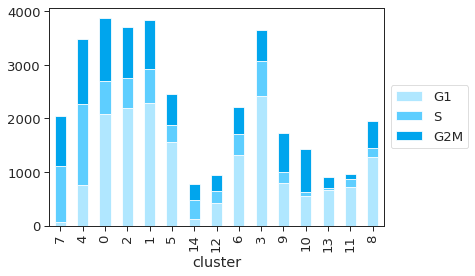

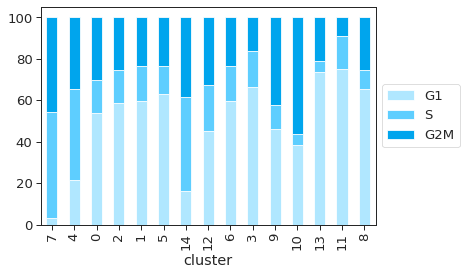

In [114]:
clust_order = colors.sort_values('clust_order').org_clust.values
cl.loc[clust_order,order].plot.bar(stacked=True, color = color)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
cl_pct.loc[clust_order,order].plot.bar(stacked=True, color = color)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))